  # Distributed Deep Reinforcement Learning for Multiple Stock Trading

  <a id='0'></a>
  # Part 1. Problem Definition

  This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

  The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


  * Action: The action space describes the allowed actions that the agent interacts with the
  environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
  selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
  an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
  10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

  * Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
  values at state s′ and s, respectively

  * State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
  our trading agent observes many different features to better learn in an interactive environment.

  * Environment: Dow 30 consituents


  The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


  <a id='1'></a>
  # Part 2. Getting Started- Load Python Packages

  <a id='1.1'></a>
  ## 2.1. Install all required packages


In [1]:
# !pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git


  <a id='1.2'></a>
  ## 2.2. Check if the additional packages needed are present, if not install them.
  * Yahoo Finance API
  * pandas
  * numpy
  * matplotlib
  * stockstats
  * OpenAI gym
  * stable-baselines
  * tensorflow
  * pyfolio

  <a id='1.3'></a>
  ## 2.3. Import Packages

In [2]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from finrl.apps import config
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading_np import StockTradingEnv
# from drl_agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_baseline

import impala

from pprint import pprint
from absl import flags

FLAGS = flags.FLAGS
FLAGS(sys.argv, known_only=True)

import sys
sys.path.append("../FinRL-Library")

import itertools
import logging

logging.basicConfig(level=logging.INFO)


/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


  <a id='1.4'></a>
  ## 2.4. Create Folders

In [3]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)


  <a id='2'></a>
  # Part 3. Download Data
  Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
  * FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
  * Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




  -----
  class YahooDownloader:
      Provides methods for retrieving daily stock data from
      Yahoo Finance API

      Attributes
      ----------
          start_date : str
              start date of the data (modified from config.py)
          end_date : str
              end date of the data (modified from config.py)
          ticker_list : list
              a list of stock tickers (modified from config.py)

      Methods
      -------
      fetch_data()
          Fetches data from yahoo API


In [4]:
# from config.py start_date is a string
config.START_DATE


'2009-01-01'

In [5]:
# from config.py end_date is a string
config.END_DATE


'2021-10-31'

In [6]:
print(config.DOW_30_TICKER)


['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [7]:
data_filename = 'processed_data.csv'
data_path = os.path.join(config.DATA_SAVE_DIR, data_filename)

if os.path.exists(data_path):
    data = pd.read_csv(data_path)
else:
    data = None


In [8]:
if data is None:
  import yfinance as yf
  data_df = pd.DataFrame()
  for tic in config.DOW_30_TICKER:
      temp_df = yf.download(tic, start='2009-01-01', end='2021-12-31')
      temp_df["tic"] = tic
      data_df = data_df.append(temp_df)

  data_df = data_df.reset_index()
  data_df.columns = [
      "date", "open",
      "high", "low",
      "close", "adjcp",
      "volume", "tic",
  ]

  # create day of the week column (monday = 0)
  data_df["day"] = data_df["date"].dt.dayofweek
  # convert date to standard string format, easy to filter
  data_df["date"] = data_df.date.apply(lambda x: x.strftime("%Y-%m-%d"))
  # drop missing data
  data_df = data_df.dropna()
  data_df = data_df.reset_index(drop=True)
  print("Shape of DataFrame: ", data_df.shape)
  # print("Display DataFrame: ", data_df.head())

  data_df = data_df.sort_values(
      by=["date", "tic"]).reset_index(drop=True)


  # Part 4: Preprocess Data
  Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
  * Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
  * Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [9]:
if data is None:
    fe = FeatureEngineer(
        use_technical_indicator=True,
        tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
        use_vix=True,
        use_turbulence=True,
        user_defined_feature = False)

    processed = fe.preprocess_data(data_df)
    
    list_ticker = processed["tic"].unique().tolist()
    list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
    combination = list(itertools.product(list_date,list_ticker))

    processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
    processed_full = processed_full[processed_full['date'].isin(processed['date'])]
    processed_full = processed_full.sort_values(['date','tic'])

    processed_full = processed_full.fillna(0)
    processed_full.to_csv(data_path, index=False)
    
else:
    processed_full = data

processed_full['date'] = pd.to_datetime(processed_full['date'])
processed_full.head(10)


,date,tic,open,high,low,close,adjcp,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,3.241071,2.778781,746015200.0,4.0,0.0,3.502909,3.116019,100.0,66.666667,100.0,3.241071,3.241071,39.189999,0.0
1,2009-01-02,AMGN,58.590000,59.080002,57.750000,58.990002,45.615875,6547900.0,4.0,0.0,3.502909,3.116019,100.0,66.666667,100.0,58.990002,58.990002,39.189999,0.0
2,2009-01-02,AXP,18.570000,19.520000,18.400000,19.330000,15.579445,10955700.0,4.0,0.0,3.502909,3.116019,100.0,66.666667,100.0,19.330000,19.330000,39.189999,0.0
3,2009-01-02,BA,42.799999,45.560001,42.779999,45.250000,33.941101,7010200.0,4.0,0.0,3.502909,3.116019,100.0,66.666667,100.0,45.250000,45.250000,39.189999,0.0
4,2009-01-02,CAT,44.910000,46.980000,44.709999,46.910000,32.475800,7117200.0,4.0,0.0,3.502909,3.116019,100.0,66.666667,100.0,46.910000,46.910000,39.189999,0.0
5,2009-01-02,CRM,8.025000,8.550000,7.912500,8.505000,8.505000,4069200.0,4.0,0.0,3.502909,3.116019,100.0,66.666667,100.0,8.505000,8.505000,39.189999,0.0
6,2009-01-02,CSCO,16.410000,17.000000,16.250000,16.959999,12.349074,40980600.0,4.0,0.0,3.502909,3.116019,100.0,66.666667,100.0,16.959999,16.959999,39.189999,0.0
7,2009-01-02,CVX,74.230003,77.300003,73.580002,76.519997,45.650539,13695900.0,4.0,0.0,3.502909,3.116019,100.0,66.666667,100.0,76.519997,76.519997,39.189999,0.0
8,2009-01-02,DIS,22.760000,24.030001,22.500000,23.920000,20.597494,9796600.0,4.0,0.0,3.502909,3.116019,100.0,66.666667,100.0,23.920000,23.920000,39.189999,0.0
9,2009-01-02,GS,84.019997,87.620003,82.190002,86.760002,71.587746,14088500.0,4.0,0.0,3.502909,3.116019,100.0,66.666667,100.0,86.760002,86.760002,39.189999,0.0


  <a id='4'></a>
  # Part 5. Design Environment
  Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

  Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

  The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [10]:
train = data_split(processed_full, '2009-01-01','2020-07-01')
trade = data_split(processed_full, '2020-07-01','2021-10-31')
print(len(train))
print(len(trade))


83897
9773


In [11]:
train.tail()


,date,tic,open,high,low,close,adjcp,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2892,2020-06-30,UNH,288.570007,296.450012,287.660004,294.950012,288.628387,2932900.0,1.0,-0.372631,312.687984,278.358021,52.084626,-28.367095,1.846804,296.135668,289.078333,30.43,12.923923
2892,2020-06-30,V,191.490005,193.750000,190.160004,193.169998,191.412445,9040100.0,1.0,1.041698,201.285492,187.401509,52.961025,-51.428315,2.013358,193.927334,184.120167,30.43,12.923923
2892,2020-06-30,VZ,54.919998,55.290001,54.360001,55.130001,50.990154,17414800.0,1.0,-0.485633,59.005858,53.327142,47.865150,-50.671335,8.508886,55.825333,56.351000,30.43,12.923923
2892,2020-06-30,WBA,42.119999,42.580002,41.759998,42.389999,39.892536,4782100.0,1.0,-0.135283,46.270640,39.622361,48.504217,-14.266714,1.500723,42.498000,42.519167,30.43,12.923923
2892,2020-06-30,WMT,119.220001,120.129997,118.540001,119.779999,116.994621,6836400.0,1.0,-0.944696,123.237586,117.086413,47.908402,-69.838490,3.847271,121.498333,123.698167,30.43,12.923923


In [12]:
trade.head()


,date,tic,open,high,low,close,adjcp,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-07-01,AAPL,91.279999,91.839996,90.977501,91.027496,90.151405,110737200.0,2.0,3.042301,93.857116,81.181381,62.736924,107.472310,29.730532,84.982083,78.758125,28.620001,52.952935
0,2020-07-01,AMGN,235.520004,256.230011,232.580002,255.119995,244.159149,6575800.0,2.0,3.746028,246.880078,212.689919,61.063530,272.795104,46.806139,228.248332,230.089333,28.620001,52.952935
0,2020-07-01,AXP,95.250000,96.959999,93.639999,94.050003,92.347771,3301000.0,2.0,-0.437417,113.325929,89.959072,48.232361,-68.223064,3.142448,99.754667,93.042667,28.620001,52.952935
0,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,180.320007,49036700.0,2.0,5.442064,220.721139,160.932863,50.908570,24.220608,15.932920,176.472335,155.614168,28.620001,52.952935
0,2020-07-01,CAT,129.380005,129.399994,125.879997,126.059998,121.818474,2807800.0,2.0,1.312021,136.479678,118.434322,52.739826,35.366374,14.457404,124.765666,118.866833,28.620001,52.952935


In [13]:
config.TECHNICAL_INDICATORS_LIST


['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [14]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 291


In [15]:
def df_to_array(df, tech_indicator_list=None, if_vix=True):
    if tech_indicator_list is None:
        tech_indicator_list = config.TECHNICAL_INDICATORS_LIST
    unique_ticker = df.tic.unique()
    if_first_time = True
    for tic in unique_ticker:
        if if_first_time:
            price_array = df[df.tic == tic][["adjcp"]].values
            # price_ary = df[df.tic==tic]['close'].values
            tech_array = df[df.tic == tic][tech_indicator_list].values
            if if_vix:
                turbulence_array = df[df.tic == tic]["vix"].values
            else:
                turbulence_array = df[df.tic == tic]["turbulence"].values
            if_first_time = False
        else:
            price_array = np.hstack(
                [price_array, df[df.tic == tic][["adjcp"]].values]
            )
            tech_array = np.hstack(
                [tech_array, df[df.tic == tic][tech_indicator_list].values]
            )
    assert price_array.shape[0] == tech_array.shape[0]
    assert tech_array.shape[0] == turbulence_array.shape[0]
    print("Successfully transformed into array")

    return dict(
        price_array=price_array,
        tech_array=tech_array,
        turbulence_array=turbulence_array
    )
    


  ## Environment for Training


In [16]:
e_train_cfg = dict(
    if_train = True,
    **df_to_array(train)
)
e_train_gym = StockTradingEnv(e_train_cfg, min_stock_rate=0.01)



Successfully transformed into array


  ## Trading
  Assume that we have $1,000,000 initial capital at 2020-07-01. We use the DDPG model to trade Dow jones 30 stocks.

  ### Set turbulence threshold
  Set the turbulence threshold to be greater than the maximum of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [17]:
data_risk_indicator = processed_full[(processed_full.date<'2020-07-01') & (processed_full.date>='2009-01-01')]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])


In [18]:
insample_risk_indicator.vix.describe()


count    2893.000000
mean       18.824245
std         8.489311
min         9.140000
25%        13.330000
50%        16.139999
75%        21.309999
max        82.690002
Name: vix, dtype: float64

In [19]:
insample_risk_indicator.vix.quantile(0.996)


57.40400183105453

In [20]:
insample_risk_indicator.turbulence.describe()


count    2893.000000
mean       34.537543
std        43.464459
min         0.000000
25%        15.170655
50%        24.296342
75%        39.272185
max       650.976029
Name: turbulence, dtype: float64

In [21]:
insample_risk_indicator.turbulence.quantile(0.996)


278.510852681742

In [22]:
e_trade_cfg = dict(
    if_train = False,
    **df_to_array(trade)
)
e_trade_gym = StockTradingEnv(e_trade_cfg, min_stock_rate=0.01)


Successfully transformed into array


 # Part 6: Implement DRL Algorithms

[IMPALA](p2.png)
Left: Single Learner. Each actor generates trajectories
and sends them via a queue to the learner. Before starting the next
trajectory, actor retrieves the latest policy parameters from learner.
Right: Multiple Synchronous Learners. Policy parameters are
distributed across multiple learners that work synchronously.

[Timeline for one unroll with 4 steps using different architectures](p1.png)
Strategies shown in (a) and (b) can lead to low GPU
utilisation due to rendering time variance within a batch. In (a),
the actors are synchronised after every step. In (b) after every n
steps. IMPALA (c) decouples acting from learning

 ## Training

In [23]:
FLAGS.total_steps = 80000

In [24]:
impala.set_env(e_train_gym)
impala.train(FLAGS)

Creating log directory: impala_logs/impala-20220117-141736
[INFO:4081 file_writer:104 2022-01-17 14:17:36,187] Creating log directory: impala_logs/impala-20220117-141736
Symlinked log directory: impala_logs/latest
[INFO:4081 file_writer:117 2022-01-17 14:17:36,194] Symlinked log directory: impala_logs/latest
Saving arguments to impala_logs/impala-20220117-141736/meta.json
[INFO:4081 file_writer:129 2022-01-17 14:17:36,197] Saving arguments to impala_logs/impala-20220117-141736/meta.json
Saving messages to impala_logs/impala-20220117-141736/out.log
[INFO:4081 file_writer:137 2022-01-17 14:17:36,200] Saving messages to impala_logs/impala-20220117-141736/out.log
Saving logs data to impala_logs/impala-20220117-141736/logs.csv
[INFO:4081 file_writer:147 2022-01-17 14:17:36,204] Saving logs data to impala_logs/impala-20220117-141736/logs.csv
Saving logs' fields to impala_logs/impala-20220117-141736/fields.csv
[INFO:4081 file_writer:148 2022-01-17 14:17:36,207] Saving logs' fields to impala_l

  ### Trade

  DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends.

  Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [25]:
impala.set_env(e_trade_gym)
account_values, actions = impala.test(FLAGS)
df_account_value = pd.DataFrame(dict(date=trade.date[~trade.date.duplicated(keep='last')],
                                     account_value=account_values))
df_account_value


[INFO:4081 impala:551 2022-01-17 14:21:04,566] Episode ended after 336 steps. Return: 1.5


Test Finished!


,date,account_value
0,2020-07-01,1.000000e+06
1,2020-07-02,9.999926e+05
2,2020-07-06,1.000212e+06
3,2020-07-07,9.997378e+05
4,2020-07-08,9.999497e+05
...,...,...
332,2021-10-25,1.529195e+06
333,2021-10-26,1.531790e+06
334,2021-10-27,1.519423e+06
335,2021-10-28,1.534685e+06


  <a id='6'></a>
  # Part 7: Backtest Our Strategy
  Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

  <a id='6.1'></a>
  ## 7.1 BackTestStats
  pass in df_account_value, this information is stored in env class


In [26]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')


==============Get Backtest Results===========
Annual return          0.378852
Cumulative returns     0.536658
Annual volatility      0.157592
Sharpe ratio           2.124236
Calmar ratio           5.222514
Stability              0.923293
Max drawdown          -0.072542
Omega ratio            1.438449
Sortino ratio          3.459839
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.311586
Daily value at risk   -0.018526
dtype: float64


In [27]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI",
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


[DEBUG:4081 connectionpool:813 2022-01-17 14:21:04,755] Starting new HTTPS connection (1): query2.finance.yahoo.com:443


==============Get Baseline Stats===========


[DEBUG:4081 connectionpool:393 2022-01-17 14:21:04,824] https://query2.finance.yahoo.com:443 "GET /v8/finance/chart/%5EDJI?period1=1593561600&period2=1635465600&interval=1d&includePrePost=False&events=div%2Csplits HTTP/1.1" 200 None


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (336, 8)
Annual return          0.279047
Cumulative returns     0.388402
Annual volatility      0.139129
Sharpe ratio           1.844560
Calmar ratio           3.124551
Stability              0.918675
Max drawdown          -0.089308
Omega ratio            1.358960
Sortino ratio          2.734872
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.052781
Daily value at risk   -0.016510
dtype: float64


In [28]:
df_account_value.loc[0,'date']


Timestamp('2020-07-01 00:00:00')

In [29]:
df_account_value.loc[len(df_account_value)-1,'date']


Timestamp('2021-10-29 00:00:00')

  <a id='6.2'></a>
  ## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (336, 8)


Start date,2020-07-01
End date,2021-10-29
Total months,16
,Backtest
Annual return,37.885%
Cumulative returns,53.666%
Annual volatility,15.759%
Sharpe ratio,2.12
Calmar ratio,5.22
Stability,0.92
Max drawdown,-7.254%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.25,2021-08-12,2021-09-21,2021-10-25,53
1,7.21,2021-06-04,2021-06-18,2021-08-06,46
2,7.03,2021-01-14,2021-01-29,2021-02-08,18
3,6.17,2020-10-12,2020-10-30,2020-11-09,21
4,4.47,2021-03-12,2021-03-24,2021-04-16,26


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


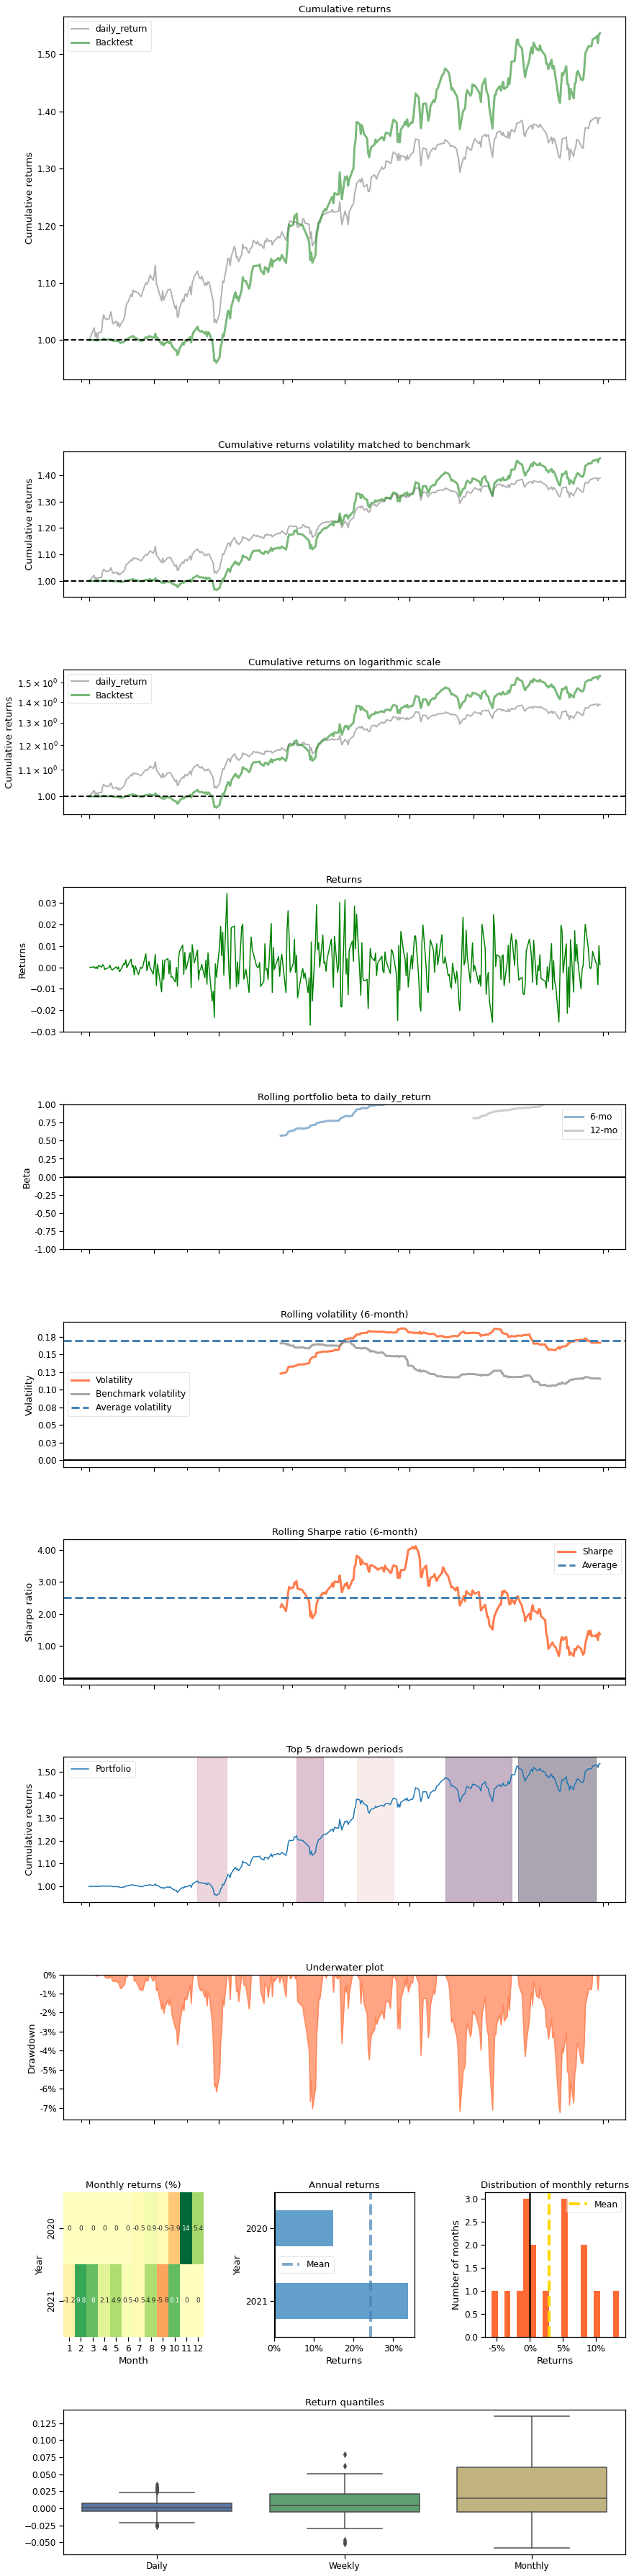

In [30]:
print("==============Compare to DJIA===========")

logging.disable(logging.DEBUG)

# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])


 <a id='6.3'></a>
 ## 7.3 TransactionPlot

In [31]:
df_actions = pd.DataFrame(actions,
                          index=df_account_value.date[:-1],
                          columns=trade.tic.unique())
df_actions.head()


,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,HD,HON,IBM,INTC,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-07-01,0.010787,-0.035397,0.008191,0.082505,0.047690,0.019650,0.127448,0.041464,-0.006486,0.139625,0.022039,0.005726,-0.023163,-0.027342,-0.026840,-0.101512,0.029658,-0.024336,-0.056418,0.027737,0.027904,0.041493,-0.052211,0.009630,0.020113,0.006381,-0.046594,0.010604,0.016378
2020-07-02,0.010771,-0.035341,0.008180,0.082547,0.047678,0.019647,0.127449,0.041430,-0.006474,0.139617,0.022088,0.005726,-0.023114,-0.027358,-0.026867,-0.101522,0.029659,-0.024357,-0.056414,0.027682,0.027876,0.041472,-0.052266,0.009663,0.020089,0.006421,-0.046620,0.010642,0.016278
2020-07-06,0.010755,-0.035276,0.008200,0.082588,0.047663,0.019634,0.127456,0.041388,-0.006493,0.139597,0.022147,0.005729,-0.023028,-0.027360,-0.026907,-0.101490,0.029659,-0.024345,-0.056409,0.027639,0.027866,0.041434,-0.052324,0.009697,0.020069,0.006435,-0.046640,0.010694,0.016193
2020-07-07,0.010715,-0.035163,0.008275,0.082572,0.047654,0.019556,0.127324,0.041343,-0.006488,0.139417,0.022247,0.005768,-0.022940,-0.027387,-0.026925,-0.101380,0.029703,-0.024307,-0.056376,0.027603,0.027811,0.041400,-0.052352,0.009710,0.020099,0.006433,-0.046651,0.010761,0.016080
2020-07-08,0.010702,-0.035056,0.008331,0.082566,0.047605,0.019550,0.127242,0.041282,-0.006531,0.139292,0.022297,0.005773,-0.022885,-0.027429,-0.026937,-0.101319,0.029711,-0.024250,-0.056346,0.027534,0.027773,0.041393,-0.052376,0.009744,0.020106,0.006407,-0.046677,0.010855,0.016016


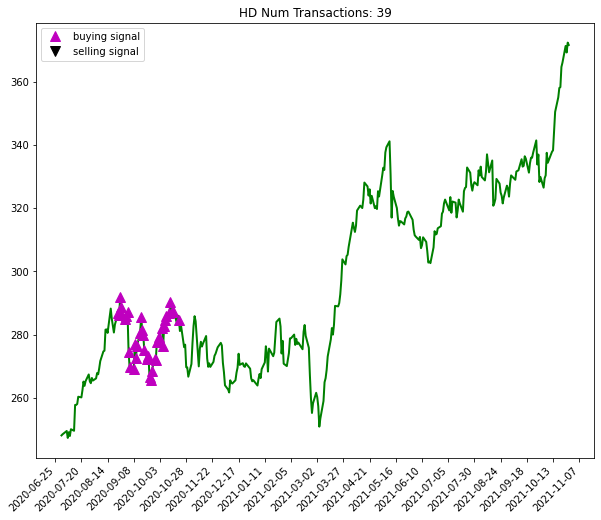

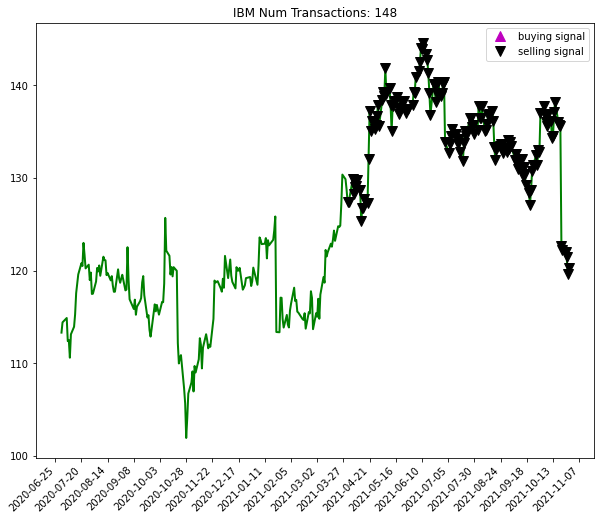

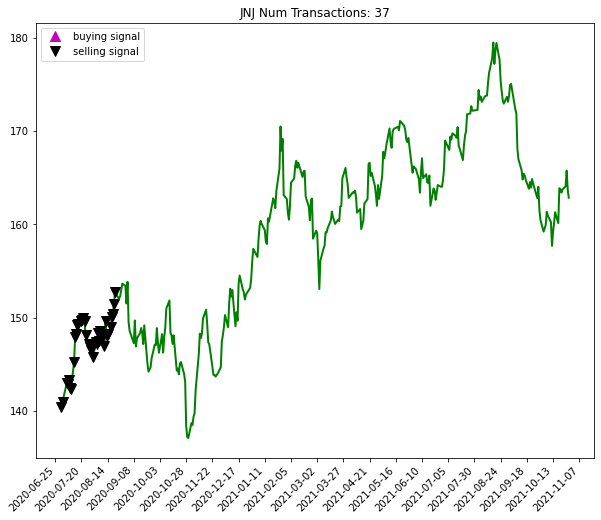

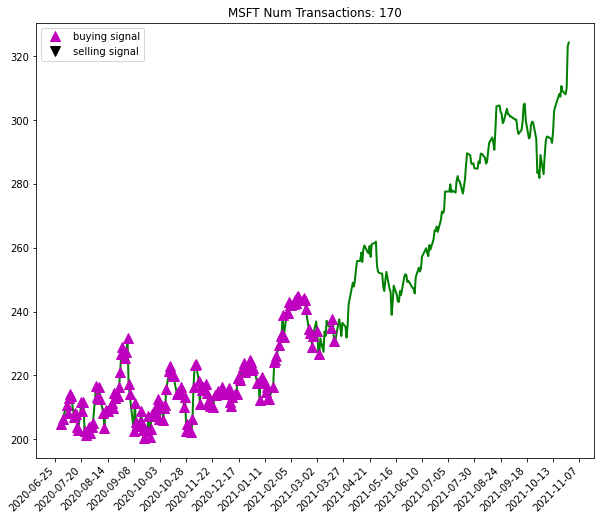

In [48]:
def trx_plot(df_trade, df_actions, tics=None):
    """Plot transactions."""
    import matplotlib.dates as mdates

    df_trx = df_actions

    if tics is None:
        tics = list(df_trx)

    for tic in tics:
        df_trx_temp = df_trx[tic]
        # df_trx_temp_sign = np.sign(df_trx_temp)
        buying_signal = df_trx_temp.apply(lambda x: x > 0.025)
        selling_signal = df_trx_temp.apply(lambda x: x < -0.025)

        num_trx = len(buying_signal[buying_signal==True]) + len(selling_signal[selling_signal==True])
        if num_trx < 10 or num_trx > 330: continue

        tic_plot = df_trade[
            (df_trade["tic"] == df_trx_temp.name)
            & (df_trade["date"].isin(df_trx.index))
        ]["close"]
        tic_plot.index = df_trx_temp.index

        plt.figure(figsize=(10, 8))
        plt.plot(tic_plot, color="g", lw=2.0)
        plt.plot(
            tic_plot,
            "^",
            markersize=10,
            color="m",
            label="buying signal",
            markevery=list(buying_signal),
        )
        plt.plot(
            tic_plot,
            "v",
            markersize=10,
            color="k",
            label="selling signal",
            markevery=list(selling_signal),
        )
        plt.title(
            f"{df_trx_temp.name} Num Transactions: {num_trx}"
        )
        plt.legend()
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=25))
        plt.xticks(rotation=45, ha="right")
        plt.show()

trx_plot(trade, df_actions)
